## Processsing the results for the annual Summer Irrigated Cropping Area (SICA) project


In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon
from multiprocessing import Pool
import sys

### Entire catchment plot

This code will produce a timeseries of annual irrigated area aggregated acrosss the entire Northern Murray Darling Basin

In [ ]:
directory = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/"
suffix = "_Irrigated_OEHandLS_masked"

In [ ]:
#list of years to help for-loop iterate through folders
x = range(1987,2019,1)
years = []
for i in x:
    nextyear = str(i + 1)[2:]
    y = str(i) + "_" + nextyear
    years.append(str(y))
# removing years that didn't work
years =  [e for e in years if e not in ('2011_12', '2012_13')]
years.sort()

folders = os.listdir(directory)
folders.sort()

area_a = []
def getIrrigatedArea(shp):
    irr = gpd.read_file(shp)
    area_a.append(irr.area.sum() / 10000)

#grab sum of irrigated area for each each and add to dataframe
for year, folder in zip(years, folders): 
    #progress indicator
    print("\r", "working on year: " + year, end = '')
    getIrrigatedArea(directory+folder+"/"+"nmdb_Summer"+ year + suffix+".shp")

#convert years back into integers for plot
years_dt = []
for i in years:
    x = int(i[:-3])
    years_dt.append(x)
#create pandas dataframe
df = pd.DataFrame.from_dict({'year':years_dt, 'irrigated area':area_a})#, '0.75+0.8':area_b, '0.70+0.75+0.8':area_c})
df = df.set_index('year')
df.to_csv("results/nmdb_plots/csvs/NMDB_annual_area.csv", header=True)

In [ ]:
#plot annual irrigated area
fontsize = 17
df = pd.read_csv("results/nmdb_plots/csvs/NMDB_annual_area.csv", index_col=0)
ax = df.plot(colormap='jet', linestyle='--', marker='o', legend=False,figsize=(20,8))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Year (Summer Nov-Mar)', fontsize=fontsize)
ax.set_ylabel('Area under Irrigation ($10^5$ Ha)', fontsize=fontsize)
ax.set_ylim(bottom=-int((df['irrigated area'].max()*0.05)), top=(df['irrigated area'].max()+(df['irrigated area'].max()*0.1)))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 3), useMathText=True)
plt.tick_params(labelsize=fontsize)
ax.grid(True, linestyle='--', alpha=0.75, color="gray")
ax.axvspan(2010, 2013, alpha=0.4, color='grey')
ax.set_facecolor('cornsilk')
ax.set_title("Northern MDB Annual Summer Irrigated Area", fontsize=fontsize)
#     plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_annual_irrigated_area.pdf",
           orientation='landscape')

### Sub-catchment plots

This script will produce a timeseries of irrigated area for each subcatchment in the directory.  This script is slow to run beacause the geopandas overlay functions are cumbersome (this is true of other libraries as well). R-tree spatial indexing is NOT used as it is imprecise with the clip boundaries.

In [ ]:
directory = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/"
individual_catchments_dir ="/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/nmdb_individual_catchments/"
suffix = "_Irrigated_OEHandLS_masked"

In [ ]:
#generate all the filenames we need for the loops
catchments = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchments.append(os.path.join(individual_catchments_dir, file))

x = range(1987,2019,1)
years = []
for i in x:
    nextyear = str(i + 1)[2:]
    y = str(i) + "_" + nextyear
    years.append(str(y))
# removing years that didn't work due to bad satellite coverage
years =  [e for e in years if e not in ('2011_12', '2012_13')]
years.sort()

years_dt = []
for i in years:
    x = int(i[:-3])
    years_dt.append(x)

folders = os.listdir(directory)
folders.sort()

In [ ]:
#multithreaded version
def subcatchmentarea(catchment):
    print("working on "+ catchment[85:-4])
    area_a = []
    for year, folder in zip(years, folders): 
        #progress indicator
        print("\r", "working on "+ catchment[85:-4] + ": " + year, end = '')
        #get the irrigated area shapefile
        irr = gpd.read_file(directory+folder+"/"+"nmdb_Summer"+ year + suffix+".shp")
        catch = gpd.read_file(catchment)
        irr_clip = gpd.overlay(irr, catch, how='intersection')
        area_a.append(irr_clip.area.sum() / 10000) 
    #create pandas dataframe
    df = pd.DataFrame.from_dict({'year':years_dt, 'irr_area':area_a})
    df = df.set_index('year')
    df.to_csv("results/nmdb_plots/csvs/annual_area/" + catchment[85:-4] + "_annual_area.csv", header=True)
    print("finished "+ catchment[85:-4])

#singlethreaded version
# for i in catchments:
#     subcatchmentarea(i)

# multithreaded version
pool = Pool(4)    
pool.map(subcatchmentarea, catchments)

In [ ]:
#create plot and save
folder = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb_plots/csvs/annual_area/"

fig, axs = plt.subplots(5,2, figsize=(25, 30), facecolor='w', edgecolor='k')
files = os.listdir(folder)
files.sort()

for ax,file in zip(axs.ravel(), files):
    fontsize = 23
    df = pd.read_csv(folder+file, index_col=0)
    df.plot(ax=ax,colormap='jet', linestyle='--', marker='o', legend = False)
    col_name = 'irr_area'
    if file[:-16] == 'PAROO RIVER':
        t = [200]
        bottom = -10
        top = 225
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([str(i)+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-95)
    elif file[:-16] == 'MOONIE RIVER':
        t = [round(int(df[col_name].max()), -2)]
        bottom = -100
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-110)
    elif file[:-16] == 'CASTLEREAGH RIVER':
        t = [round(int(df[col_name].max()), -2)]
        bottom = -250
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-110)
    elif file[:-16] == 'DARLING RIVER' or file[:-16] == 'WARREGO RIVER':
        t = [round(int(df[col_name].max()), -2)]
        bottom = -750
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-130)
    else:
        t = [round(int(df[col_name].max()), -3)]
        bottom = -3000
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-145)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_label_text("")
#     ax.grid(True, linestyle='--', alpha=0.75, axis='y', color="gray")
    ax.axvspan(2010, 2013, alpha=0.4, color='k')
    ax.tick_params(length=8, width=4,labelsize=fontsize)
    ax.set_title(file[:-16], fontsize=fontsize)
    ax.set_facecolor('cornsilk')

plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_annual_area_subcatchment.pdf",
   orientation='portrait', dpi=300)

## Cumulative growth in new irrigated areas



The script is divided into four sections

1. The first section cumulatively unions the annual irrigated area files. ie. years 1987-1988 are unioned, then 1987-88-89, then 1987-88-89-90 etc. These unioned shapefiles are exported to a folder called 'interim-NMDB'. This code will take hours to run.

2. The second part of the script finds the difference in irrigated area between adjacent time ranges. ie. difference between '1987-88' and '1987-88-89,' etc.  Shapefiles of the difference are exported. The cumulative sum is then computed on these areal differences, and the result is added to a dataframe and exported as a csv file. This section will take a few hours to complete

3. The 3rd part of the script clips the results of part 2 to each subcatchment and finds the cumulative sum, exporting the results as a csv.

4. Plotting of the sub-catchment cumulative trends

In [ ]:
directory = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/"
individual_catchments_dir ="data/spatial/nmdb_individual_catchments/"
AOI = "nmdb_Summer"
interim_results = "results/nmdb_plots/shapes/interim_NMDB/"
suffix = "_Irrigated_OEHandLS_masked"

#### Part 1.

Creating the cumulatively unioned files

In [ ]:
# create list of time strings for function
timerangelist = [str(t) for t in range(1987,2019,1)]
timerangelist = [e for e in timerangelist if e not in ('2011', '2012')]

In [ ]:
def cumulativelyUnion(timerangelist, shapes):
    for t in timerangelist:
        print("\r", "working on "+t, end = '')
        #open the year and add it to a list
        nextyear= str(int(t)+1)[2:]
        irr = gpd.read_file(directory+AOI+t+"_"+nextyear+"/"+AOI+t+"_"+nextyear+suffix+".shp")
        shapes.append(irr)
        print("..length of [shapes] = "+str(len(shapes)))
        #now do the concatentation & dissolve
        x = pd.concat(shapes)
        x['DISS_ID'] = 1
        x = x.dissolve(by='DISS_ID', aggfunc='sum')
        x['year_range'] = "1987_" + t
        x['catchment'] = "NMDB"
        print("...exporting "+t)
        x.to_file(interim_results+"/NMDB_1987_"+t+".shp")

In [ ]:
shapes=[]
cumulativelyUnion(timerangelist,shapes)

#### Part 2. 

calculate cumulative new area for entire basin

In [ ]:
def areaofFirstYear(area_list):
    #open the first timerange
    firstyear = gpd.read_file(interim_results + "/NMDB_1987_1987.shp")
    area_list.append((firstyear.area.sum()/ 10000))
        
def getdifferenceAreas(yr1, yr2, area_list):
    df1 = gpd.read_file(interim_results+"/NMDB_1987_"+ yr1 + ".shp")
    df2 = gpd.read_file(interim_results+"/NMDB_1987_"+ yr2 + ".shp")
    diff = gpd.overlay(df2, df1, how='difference')
    diff = diff.explode() #need to explode to filter for small areas
    diff['area_diff'] = diff
    toosmall = diff['area_diff'] >= 100000 #less than 10ha
    diff = diff[toosmall]
    print("...exporting "+yr2+"_minus_"+yr1)
    diff.to_file("results/nmdb_plots/shapes/difference_NMDB/NMDB_"+yr2+"_minus_"+yr1+".shp")
    area_list.append(float(diff.area.sum() / 10000))
        
def runpart2(area_list):
    areaofFirstYear(area_list)
    for i in range(1, len(timerangelist)):
        print("\r", "working on "+ timerangelist[i], end = '')
        getdifferenceAreas(timerangelist[i-1],timerangelist[i], area_list)

In [ ]:
area_list = []
os.mkdir("results/nmdb_plots/shapes/difference_NMDB")
runpart2(area_list)

#create empty dataframe to add results too
df = pd.DataFrame(index=timerangelist)
df['NMDB'] = area_list
df = df.cumsum(axis = 0)
df.to_csv("results/nmdb_plots/csvs/NMDB_cumulative_area.csv", header=True)

#### Cumulative whole-of-catchment plot

In [ ]:
fontsize = 17
df = pd.read_csv("results/nmdb_plots/csvs/NMDB_cumulative_area.csv", index_col=0)
ax = df.plot(colormap='jet', linestyle='--', marker='o', legend=False,figsize=(20,8))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Year Range', fontsize=fontsize)
ax.set_ylabel('Irrigatable Area ($10^6$ Ha)', fontsize=fontsize)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 3), useMathText=True)
ax.set_ylim(bottom=int((df['NMDB'].max()*0.35)), top=(df['NMDB'].max()+(df['NMDB'].max()*0.05)))
plt.tick_params(labelsize=fontsize)
ax.grid(True, linestyle='--', alpha=0.75, color="gray")
ax.axvspan(2010, 2013, alpha=0.4, color='grey')
ax.set_facecolor('cornsilk')
ax.set_title("Northern MDB Cumulative Irrigable area", fontsize=fontsize)
# plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_cumulative_area.pdf",
           orientation='landscape')

#### Part 3 

Subcatchment cumulative area

In [ ]:
#reset the location strings
individual_catchments_dir ="data/spatial/nmdb_individual_catchments/"
basin_epochs = "results/nmdb_plots/shapes/difference_NMDB/"

# create list of time strings for function
timerangelist = [str(t) for t in range(1987,2019,1)]
timerangelist = [e for e in timerangelist if e not in ('2011', '2012')]

#get a list of catchment names as input to functions
catchments = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchments.append(file[:-4])

#create list of catchment shapefiles
catchment_shps = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchment_shps.append(os.path.join(individual_catchments_dir, file))

#get list of NMDB difference files 
epochs = []
for file in os.listdir(basin_epochs):
    if file.endswith(".shp"):
        epochs.append(os.path.join(basin_epochs, file))
epochs.sort()

In [ ]:
for catch_shp, catchment in zip(catchment_shps, catchments):
    area_list = []
    try:
        print("; working on " + catchment)
        clipBoundary = gpd.read_file(catch_shp)
        firstyear = gpd.read_file(interim_results+ "NMDB_1987_1987.shp")
        firstYearClip = gpd.overlay(firstyear, clipBoundary, how='intersection')
        area_list.append((firstYearClip.area.sum()/ 10000))
    except:
        area_list.append(0)

    for epoch in epochs:	
        print("\r", " "+ epoch[47:62], end = '')
        catch = gpd.read_file(catch_shp)
        irr = gpd.read_file(epoch)
        diff = gpd.overlay(irr, catch, how='intersection')
        area_list.append(float(diff.area.sum() / 10000))
    
    df = pd.DataFrame(index=timerangelist)
    df[catchment] = area_list
    df = df.cumsum(axis = 0)
    df.to_csv("results/nmdb_plots/csvs/cumulative/" + catchment + "_cumulative_area.csv", header=True)

#### Part 4 

plotting of sub-catchment cumulative area

In [ ]:
# create plot and save
folder = "results/nmdb_plots/csvs/cumulative/"

fig, axs = plt.subplots(5,2, figsize=(25, 30), edgecolor='k')
files = os.listdir(folder)
files.sort()
for ax,file in zip(axs.ravel(), files):
    fontsize = 23
    df = pd.read_csv(folder+file, index_col=0)
    df.plot(ax=ax,colormap='jet', linestyle='--', marker='o', legend = False)
    if file[:-20] == 'PAROO RIVER':
        t = [10, 200]
        bottom = -10
        top = 225
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([str(i)+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-100)
    elif file[:-20] == 'MOONIE RIVER':
        t = [600, round(int(df[file[:-20]].max()), -2)]
        bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.025
        top = df[file[:-20]].max()+(df[file[:-20]].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-115)
    elif file[:-20] == 'CASTLEREAGH RIVER':
        t = [round(int(df[file[:-20]].min()), -2) , round(int(df[file[:-20]].max()), -3)]
        bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.3
        top = df[file[:-20]].max()+(df[file[:-20]].max()*0.1)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-120)
    elif file[:-20] == 'WARREGO RIVER':
        t = [round(int(df[file[:-20]].min()), -3) , round(int(df[file[:-20]].max()), -3)]
        bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.2
        top = df[file[:-20]].max()+(df[file[:-20]].max()*0.075)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-145)
    elif file[:-20] == 'DARLING RIVER':
        t = [round(int(df[file[:-20]].min()), -3) , round(int(df[file[:-20]].max()), -3)]
        bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.25
        top = df[file[:-20]].max()+(df[file[:-20]].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-145)
    else:
        t = [round(int(df[file[:-20]].min()), -3) , round(int(df[file[:-20]].max()), -3)]
        bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.1
        top = df[file[:-20]].max()+(df[file[:-20]].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-145)
    ax.xaxis.set_label_text("")
    ax.tick_params(length=10, width=3, labelsize=fontsize)
    ax.set_title(file[:-20], fontsize=fontsize)
    ax.axvspan(2010, 2013, alpha=0.4, color='grey')
    ax.set_facecolor('cornsilk')
plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_cumulative_area_subcatchment.pdf",
   orientation='portrait', dpi=300)


## Change in Irrigable Area

This script will union 3 successive years of the annual irrigation files and then calculate the area through time
- Part 1 does the entire basin
- Part 2 clips the analysis to sub-catchments

### Part 1

In [2]:
directory = "/g/data/r78/cb3058/dea-notebooks/ICE_project/results/nmdb/"
individual_catchments_dir ="data/spatial/nmdb_individual_catchments/"
AOI = "nmdb_Summer"
interim_results = "results/nmdb_plots/shapes/threeYearUnion/"
suffix = "_Irrigated_OEHandLS_masked"

In [ ]:
# create list of time strings for function
t1 = [str(t) for t in range(1987,1990,1)]
t2 = [str(t) for t in range(1990,1993,1)]
t3 = [str(t) for t in range(1993,1996,1)]
t4 = [str(t) for t in range(1996,1999,1)]
t5 = [str(t) for t in range(1999,2002,1)]
t6 = [str(t) for t in range(2002,2005,1)]
t7 = [str(t) for t in range(2005,2008,1)]
t8 = [str(t) for t in range(2008,2011,1)]
t9 = [str(t) for t in range(2013,2016,1)]
t10 = [str(t) for t in range(2016,2019,1)]

timerangelist=[t1,t2,t3,t4,t5,t6,t7,t8,t9,t10]

In [ ]:
#loop through the irrigation files and union every 3 years, 
#exporting the unioned shapefile and calculating area 
area = []
for timerange in timerangelist:
    print("\r", 'working on ' + timerange[0]+"_"+timerange[-1], end ='')
    shapes = []
    year1 = str(int(timerange[0]))
    year2 = str(int(timerange[1]))
    year3 = str(int(timerange[2]))
    y1_shp = gpd.read_file(directory+AOI+year1+"_"+str(int(year1)+1)[2:]+"/"+AOI+year1+"_"+str(int(year1)+1)[2:]+suffix+".shp")
    y2_shp = gpd.read_file(directory+AOI+year2+"_"+str(int(year2)+1)[2:]+"/"+AOI+year2+"_"+str(int(year2)+1)[2:]+suffix+".shp")
    y3_shp = gpd.read_file(directory+AOI+year3+"_"+str(int(year3)+1)[2:]+"/"+AOI+year3+"_"+str(int(year3)+1)[2:]+suffix+".shp")
    shapes.extend([y1_shp, y2_shp]) #yr3_shp
    x = pd.concat(shapes)
    x['DISS_ID'] = 1
    x = x.dissolve(by='DISS_ID', aggfunc='sum')
    x['year_range'] = timerange[0]+"_"+timerange[-1]
    area.append(x.area.sum()/10000)
    print('; exporting shapefile')
    x.to_file(interim_results+timerange[0]+"_"+timerange[-1]+"_twoYearUnion.shp")

In [ ]:
threeyearstrings = ['1987_1989','1990_1992', '1993_1995','1996_1998', '1999_2001', 
                   '2002_2004','2005_2007', '2008_2010', '2013_2015','2016_2018']

df = pd.DataFrame.from_dict({'Year Range':threeyearstrings, 'Irrigated Area (ha)':area})
df = df.set_index('Year Range')
df.to_csv("results/nmdb_plots/csvs/NMDB_twoYearUnion_area.csv", header=True)

In [9]:
#plot annual irrigated area
fontsize = 17
df1 = pd.read_csv("results/nmdb_plots/csvs/NMDB_threeYearUnion_area.csv", index_col ='Year Range')
df2 = pd.read_csv("results/nmdb_plots/csvs/NMDB_twoYearUnion_area.csv", index_col ='Year Range')

fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(df1, color='blue', linestyle='--', marker='o')
ax2.plot(df2, color='blue', linestyle='--', marker='o')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax1.set_ylim(400000,850000)
ax1.set_ylabel('Ha')
ax1.grid(True, linestyle='--', alpha=0.75, color="gray")
ax2.grid(True, linestyle='--', alpha=0.75, color="gray")
ax2.set_ylim(400000,850000)
ax1.set_xlabel('Year Range', fontsize=fontsize)
ax1.set_ylabel('Area under Irrigation ($10^5$ Ha)', fontsize=fontsize)
ax2.set_xlabel('Year Range', fontsize=fontsize)
ax2.set_ylabel('Area under Irrigation ($10^5$ Ha)', fontsize=fontsize)
ax1.set_title('Three Year Union',fontsize=fontsize)
ax2.set_title('Two Year Union',fontsize=fontsize)
ax1.set_facecolor('cornsilk')
ax2.set_facecolor('cornsilk')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0, 3), useMathText=True)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0, 3), useMathText=True)
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
# plt.savefig("results/nmdb_plots/plots/NMDB_unioned_irrigated_Area.pdf",
#            orientation='landscape')

### Part 2
Subcatchments

In [3]:
#reset the location strings
individual_catchments_dir ="data/spatial/nmdb_individual_catchments/"
basin_epochs = "results/nmdb_plots/shapes/threeYearUnion/"

# create list of time strings for function
timerangelist = [str(t) for t in range(1987,2019,1)]
timerangelist = [e for e in timerangelist if e not in ('2011', '2012')]

#get a list of catchment names as input to functions
catchments = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchments.append(file[:-4])

#create list of catchment shapefiles
catchment_shps = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchment_shps.append(os.path.join(individual_catchments_dir, file))

#get list of NMDB difference files 
epochs = []
for file in os.listdir(basin_epochs):
    if file.endswith(".shp"):
        epochs.append(os.path.join(basin_epochs, file))
epochs.sort()

In [5]:
threeyearstrings = ['1987_1989','1990_1992', '1993_1995','1996_1998', '1999_2001', 
                   '2002_2004','2005_2007', '2008_2010', '2013_2015','2016_2018']

for catch_shp, catchment in zip(catchment_shps, catchments):
    area_list = []
    print(catchment)
    for epoch in epochs:	
        print("\r", " "+ epoch[41:50], end = '')
        catch = gpd.read_file(catch_shp)
        irr = gpd.read_file(epoch)
        diff = gpd.overlay(irr, catch, how='intersection')
        area_list.append(float(diff.area.sum() / 10000))
    
    df = pd.DataFrame(index=threeyearstrings)
    df[catchment] = area_list
    df.to_csv("results/nmdb_plots/csvs/unioned_areas/" + catchment + "_threeYearUnioned_area.csv", header=True)

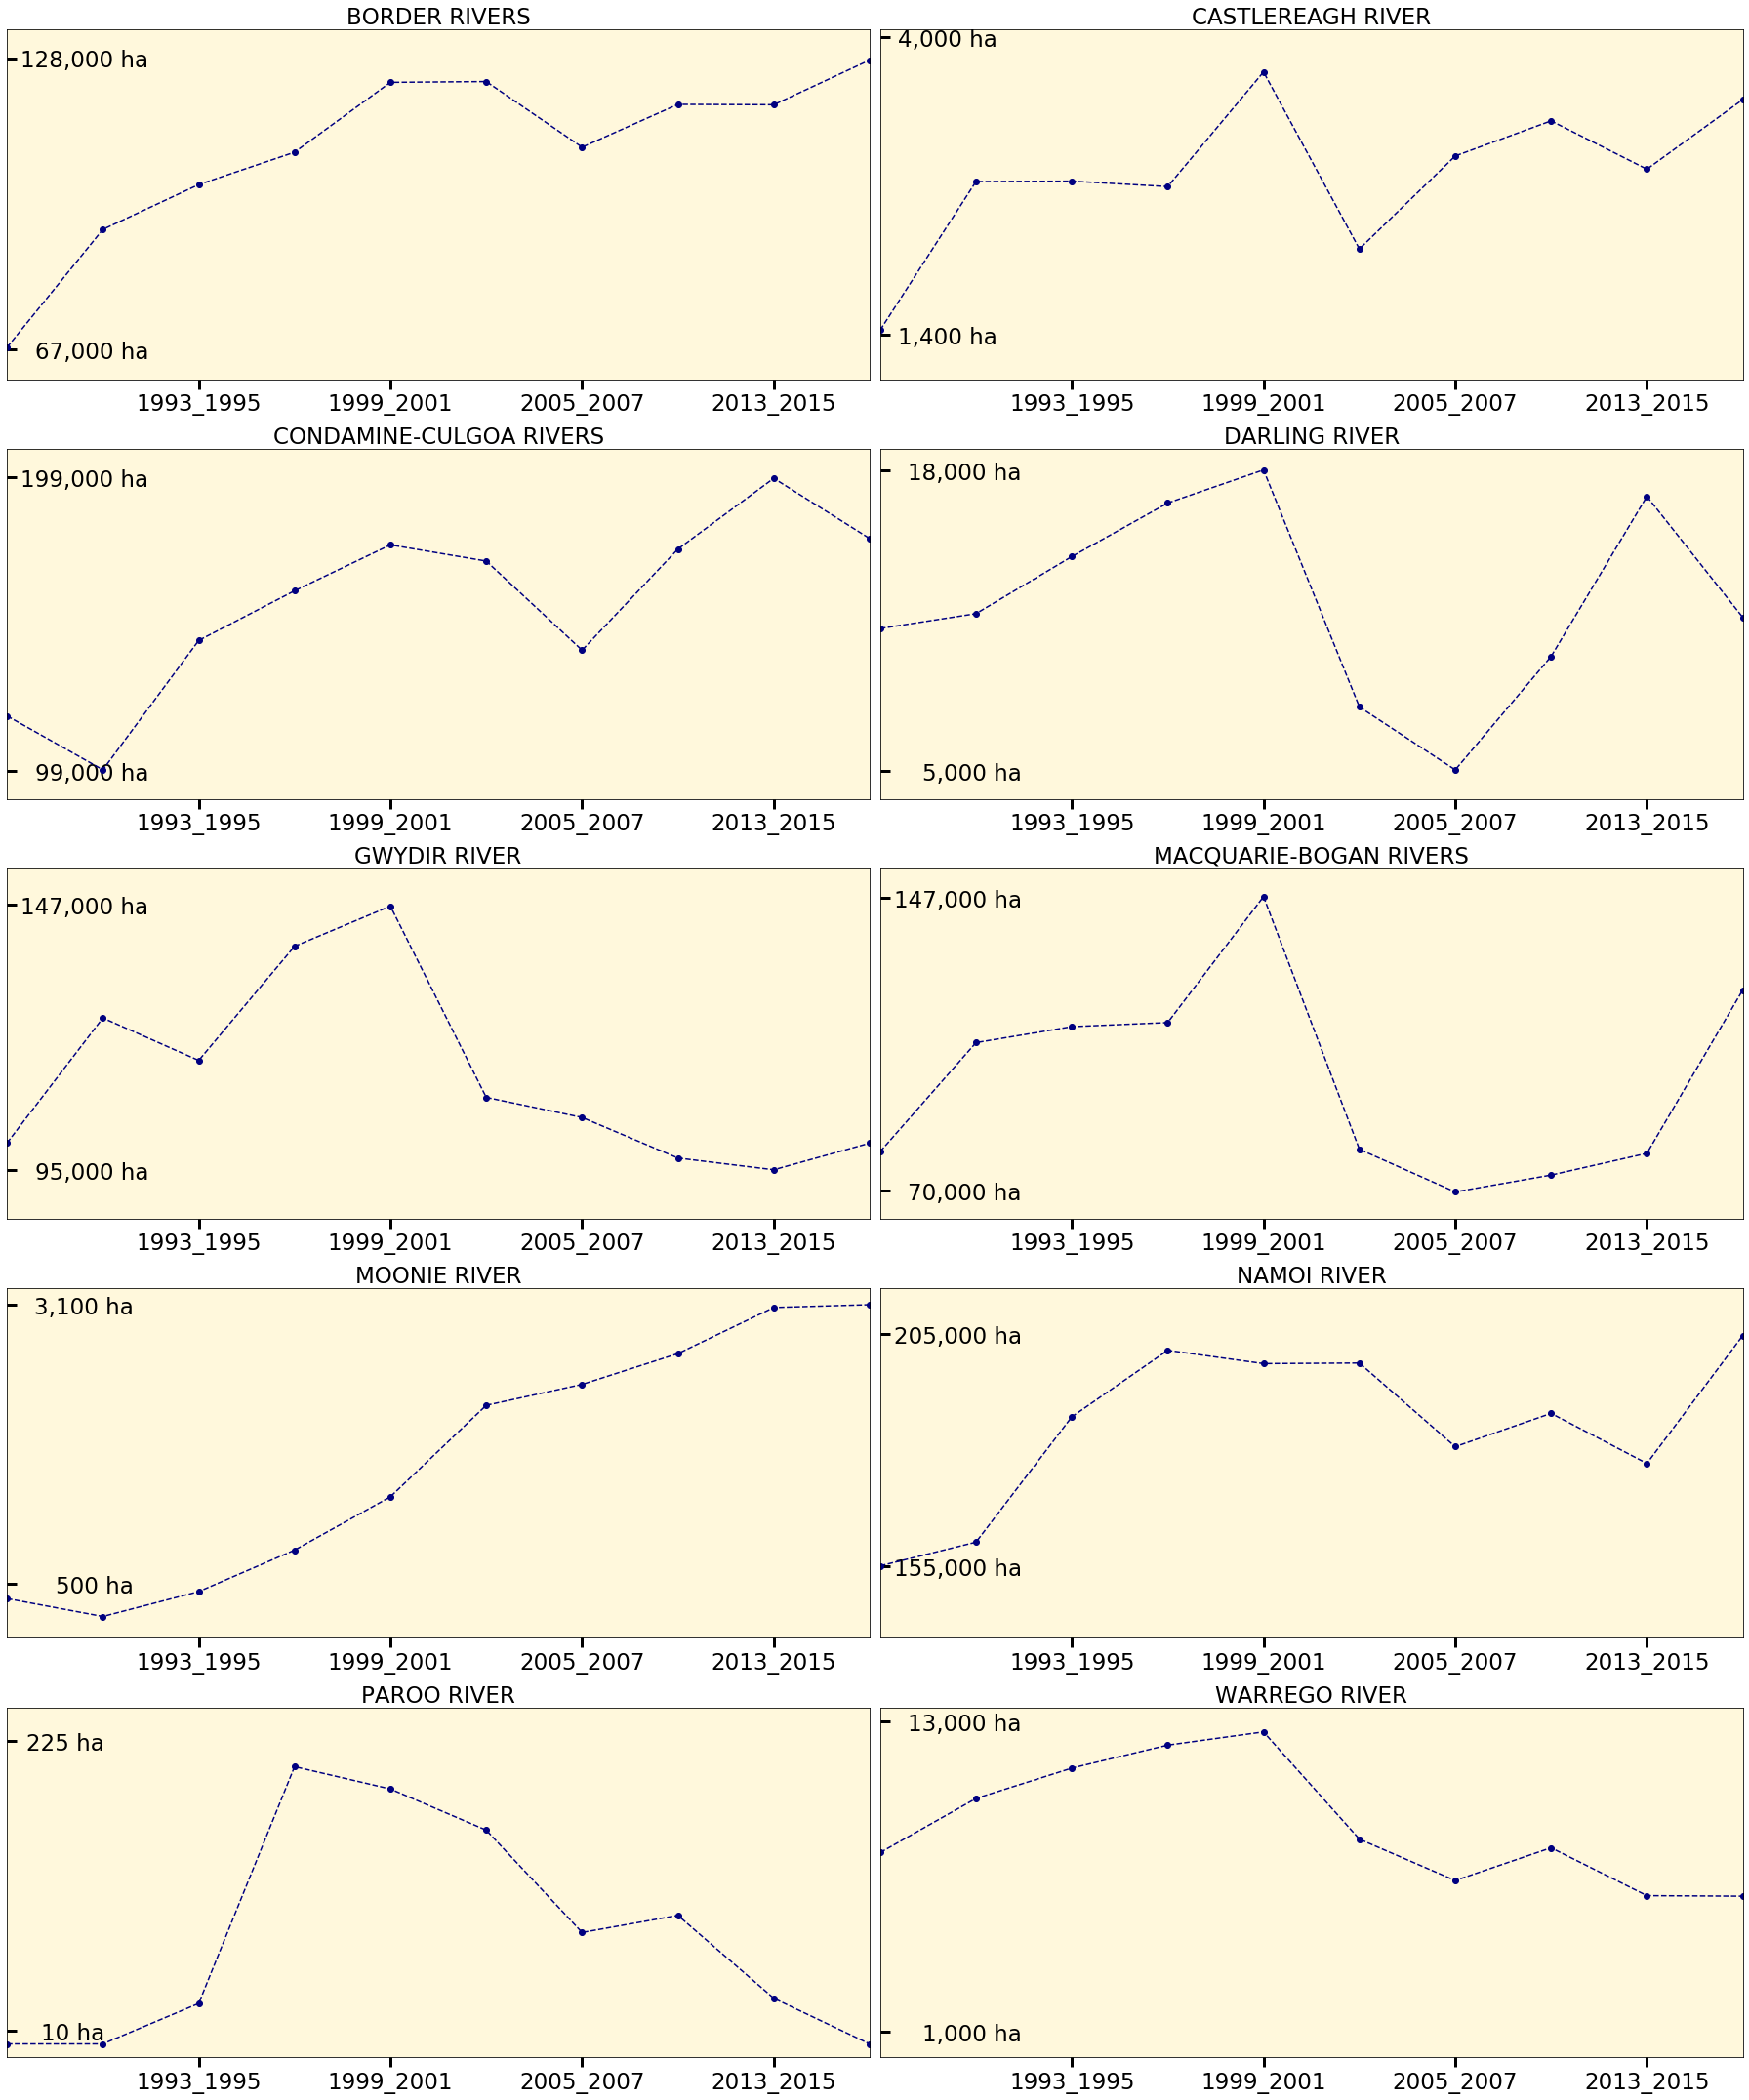

In [72]:
folder = "results/nmdb_plots/csvs/unioned_areas/"

fig, axs = plt.subplots(5,2, figsize=(25, 30), edgecolor='k')
files = os.listdir(folder)
files.sort()
for ax,file in zip(axs.ravel(), files):
    fontsize = 23
    df = pd.read_csv(folder+file, index_col=0)
    df.plot(ax=ax,colormap='jet', linestyle='--', marker='o', legend = False)
    if file[:-26] == 'PAROO RIVER':
        t = [10, 225]
        bottom = -10
        top = 250
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([str(i)+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-100)
    elif file[:-26] == 'MOONIE RIVER':
        t = [500, round(int(df[file[:-26]].max()), -2)]
        bottom = 0#df[file[:-26]].min() - df[file[:-26]].min()*0.025
        top = df[file[:-26]].max()+(df[file[:-26]].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-130)
    elif file[:-26] == 'CASTLEREAGH RIVER':
        t = [round(int(df[file[:-26]].min()), -2) , round(int(df[file[:-26]].max()), -3)]
        bottom = df[file[:-26]].min() - df[file[:-26]].min()*0.3
        top = df[file[:-26]].max()+(df[file[:-26]].max()*0.1)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-120)
    elif file[:-26] == 'WARREGO RIVER':
        t = [1000, round(int(df[file[:-26]].max()), -3)]
        bottom = 0#df[file[:-26]].min() - df[file[:-26]].min()*0.2
        top = df[file[:-26]].max()+(df[file[:-26]].max()*0.075)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-145)
    elif file[:-26] == 'DARLING RIVER':
        t = [round(int(df[file[:-26]].min()), -3) , round(int(df[file[:-26]].max()), -3)]
        bottom = df[file[:-26]].min() - df[file[:-26]].min()*0.25
        top = df[file[:-26]].max()+(df[file[:-26]].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-145)
    else:
        t = [round(int(df[file[:-26]].min()), -3) , round(int(df[file[:-26]].max()), -3)]
        bottom = df[file[:-26]].min() - df[file[:-26]].min()*0.1
        top = df[file[:-26]].max()+(df[file[:-26]].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-145)
    ax.set_xticks(np.arange(len(df))[::2][1:])
    ax.set_xticklabels(list(df.index.values)[::2][1:])
    ax.xaxis.set_label_text("")
    ax.tick_params(length=10, width=3, labelsize=fontsize)
    ax.set_title(file[:-26], fontsize=fontsize)
    ax.axvspan(2010, 2013, alpha=0.4, color='grey')
    ax.set_facecolor('cornsilk')
plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_threeyearunion_subcatchment.pdf",
   orientation='portrait', dpi=300)
